In [50]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import math
import numpy
from torch.nn.functional import pad
import torch.nn.init as init
import copy
from torch import autograd
from torchvision.utils import make_grid
from torch.optim import Adam
from torch.utils.data import DataLoader,TensorDataset
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import tqdm
import functools
import time



from generate_data import *
from network_class import *
from utils import *


In [51]:

device = 'cuda:3' #@param ['cuda', 'cpu'] {'type':'string'}

n_epochs =  30#@param {'type':'integer'}
batch_size =  1000 #@param {'type':'integer'}
lr=1e-2 #@param {'type':'number'}
tspan=[0,1]
data_name="1d_mix_gaussian"
d=1
nt=8
h=(tspan[1]-tspan[0])/nt


# f_theta = torch.nn.DataParallel(velocity_net(d=2))
f_theta = velocity_net(d=1)
# Phi = Phi(nTh=2, m=32, d=2 )
# f_theta=ResNet(d=2,hidden_unit=32,num_resblocks=3)
f_theta = f_theta.to(device)

print("total parameter is: ", count_parameters(f_theta))

optim = Adam(f_theta.parameters(), lr=lr)

# data=torch.load('data/circles_2d.pt').float()
# label=torch.ones(data.shape[0],1)
# dataset = TensorDataset(data,label)
# data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)




total parameter is:  4352


In [52]:
def log_Gaussian(x,d):
    return -d/2*math.log(2*math.pi)-torch.sum(x**2,dim=1).reshape(-1,1)/2

def Gaussian_1d(x,mu=0,sigma=1):
    return 1/(math.sqrt(2*math.pi*sigma**2))*torch.exp(-(x-mu)**2/2/sigma**2)

def grad_log_Gaussian(x):
    return -x

def stepRK4(odefun, z, net,t0, t1):
    h = t1 - t0 # step size
    z0 = z
    K = h * odefun(z0, t0, net)
    z_temp = z0 + (1.0/6.0) * K
    K = h * odefun( z0 + 0.5*K , t0+(h/2) ,net)
    z_temp =z_temp+ (2.0/6.0) * K
    K = h * odefun( z0 + 0.5*K , t0+(h/2) ,net)
    z_temp = z_temp+(2.0/6.0) * K
    K = h * odefun( z0 + K , t0+h ,net)
    z_temp = z_temp+(1.0/6.0) * K
    return z_temp



def stepRK1(odefun, z, net,t0, t1):
    z0 = z
    z_temp =z0 + (t1 - t0) * odefun(z0, t0, net)

    return z_temp

def odefun(x, t, net):
    dx = net(x,t)
    return dx


def odefun_backward(cat_var, t, net):
    x=cat_var[:,0:d]
    score=cat_var[:,d+1:-1]
    


    divergence_f=torch.zeros(x.shape[0],device=device)
    f=net(x, t).reshape(x.shape[0],-1)

    jacobian = []
    for i in range(d):
        jacobian_i = autograd.grad(f[:,i].sum(), x, create_graph=True,retain_graph=True)[0]
        # torch.autograd.functional.jacobian
        jacobian.append(jacobian_i)
    stacked_jacobbian = torch.stack(jacobian, dim=2)

    
    #精确计算divergence_f
    # for i in range(d):
    #     grad = autograd.grad(f[:,i].sum(), x, create_graph=True)[0]
    #     divergence_f+= grad[:,i]
    divergence_f = torch.diagonal(stacked_jacobbian, dim1=-2, dim2=-1).sum(-1).reshape(-1,1)
    

    # # 近似计算divergence_f
    # v=torch.randn(f.shape).to(device)
    # vf=torch.sum(f*v, dim=1)
    # a=autograd.grad(vf.sum(),x,create_graph=True)[0].reshape(x.shape[0],-1)
    # divergence_f=torch.sum(a*v, dim=1)

    
    d_log=-divergence_f.reshape(-1,1)

    #calculate jacobbian 
    grad_div_f=autograd.grad(divergence_f.sum(), x, create_graph=True,retain_graph=True)[0]
    J_mul_f=torch.bmm(stacked_jacobbian,score.unsqueeze(2)).squeeze().view(-1,1)

    d_score=(-grad_div_f-J_mul_f)
    d_penalty=torch.mean(torch.sum((f+score)**2,dim=1))*torch.ones(x.shape[0],1).to(device)*(1/2)
    # d_penalty=torch.mean(torch.sum(f**2,dim=1))*torch.ones(x.shape[0],1).to(device)*(1/2)


    # d_score=torch.zeros(x.shape[0],d).to(device)
    # d_penalty=torch.zeros(x.shape[0],1).to(device)
    return torch.cat((f,d_log,d_score,d_penalty),dim=1)


In [53]:
llh_record=[]
v_pen_record=[]
# x=torch.tensor(generate_2d(batch_size=batch_size,data_name=data_name)).float().to(device)
data=torch.load('data/mix_gaussian.pt').reshape(-1,1)[:5000,:]
label=torch.ones(data.shape[0],1)
dataset = TensorDataset(data,label)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


tqdm_epoch = tqdm.trange(n_epochs)

for epoch in tqdm_epoch:
    llh=[]
    bridge=[]
    for batch ,label in data_loader:
    
    # #resample
    # if epoch %50==0:
    #     x=torch.tensor(generate_2d(batch_size=batch_size,data_name=data_name)).float()
    #     x = x.to(device)
        x=batch.view(-1,1).to(device)

        z_temp,tk=x,0
        for k in range(nt):
            tk=h*k
            z_temp = stepRK4(odefun, z_temp , f_theta, tk, tk+h)

    


        z_terminal=z_temp
        log_terminal=log_Gaussian(x=z_terminal,d=d)
        log_temp=log_terminal
    
        score_terminal=grad_log_Gaussian(z_terminal)
        score_temp=score_terminal
        

        tk=tspan[1]
        z_back=z_terminal
        cat_var=torch.cat((z_back,log_temp,score_temp),dim=1)
        cat_var=pad(cat_var,(0,1,0,0),value=0)
        
        # print("begin---------------")
        # print("Allocated memory:", torch.cuda.memory_allocated(3)/1024**3)

        for k in  range(nt):
            cat_var= stepRK4(odefun_backward, cat_var , f_theta, tk, tk-h)
            tk-=h
        # print("Allocated memory:", torch.cuda.memory_allocated(3)/1024**3)
        # print("end---------------")



        z,log_temp,bridge_pen=cat_var[:,0:d],cat_var[:,d],-cat_var[0,-1]
        optim.zero_grad()

        loss=-torch.mean(log_temp)*10+ bridge_pen
        # loss=-torch.mean(log_temp)*10
        loss.backward()
        optim.step()
        llh_record.append(-torch.mean(log_temp).detach().cpu())
        v_pen_record.append(bridge_pen.detach().cpu())

        llh.append(-torch.mean(log_temp).detach().cpu())
        bridge.append(bridge_pen.detach().cpu())

    tqdm_epoch.set_description('Loss: {:5f} Bridge: {:5f}'.format(np.array(llh).mean(),np.array(bridge).mean() ))
    torch.save(f_theta.state_dict(), 'experiment/'+data_name+'.pth')
    if (epoch+1) % 10 == 0:
            for p in optim.param_groups:
                p['lr'] /= 2
            print("lr: ", p['lr'])
    
    
 



Loss: 2.213076 Bridge: 2.254562:  33%|███▎      | 10/30 [00:14<00:29,  1.50s/it]

lr:  0.005


Loss: 2.133032 Bridge: 2.349243:  67%|██████▋   | 20/30 [00:29<00:14,  1.50s/it]

lr:  0.0025


Loss: 2.130022 Bridge: 2.345549: 100%|██████████| 30/30 [00:44<00:00,  1.49s/it]

lr:  0.00125


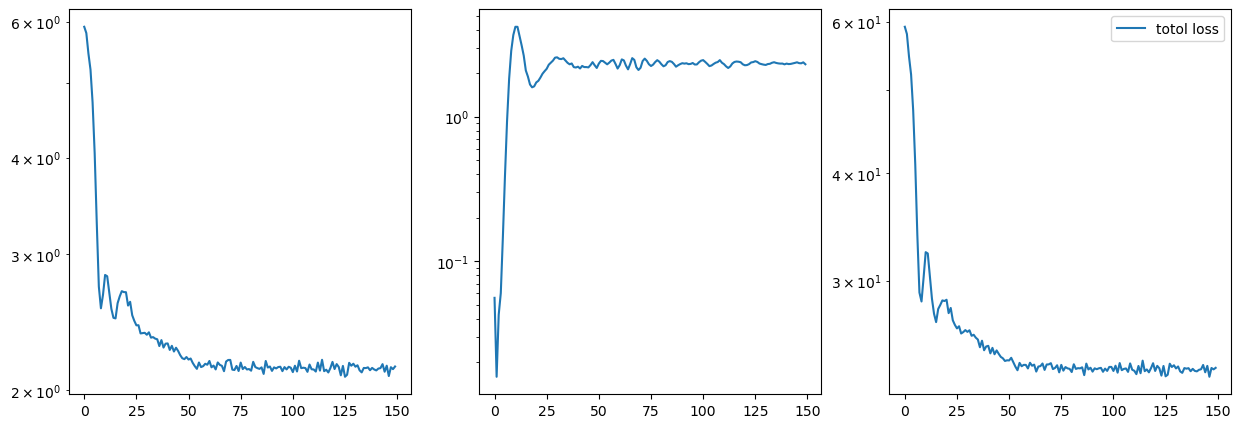

tensor(2.3015)


In [54]:

# plot_loss(llh_record)
plot_loss_all(llh_record,v_pen_record)
print(v_pen_record[-1])


tensor(2.3127)


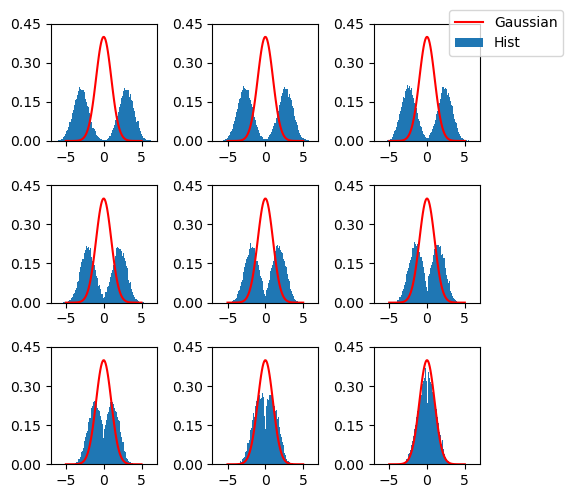

In [55]:
data=torch.load('data/mix_gaussian.pt').reshape(-1,1)
data=data[:30000].to(device)
zFull = torch.zeros(*data.shape , nt+1, device=data.device, dtype=data.dtype) # make tensor of size z.shape[0], z.shape[1], nt
zFull[:,:,0] = data
tk=0

for k in  range(nt):
    zFull[:,:,k+1] = stepRK4(odefun, zFull[:,:,k] , f_theta, tk, tk+h)
    tk += h

z_terminal=zFull[:,:,-1]
log_terminal=log_Gaussian(x=z_terminal,d=d)
log_temp=log_terminal

score_terminal=grad_log_Gaussian(z_terminal)
score_temp=score_terminal
tk=tspan[1]
z_back=z_terminal
cat_var=torch.cat((z_back,log_temp,score_temp),dim=1)
cat_var=pad(cat_var,(0,1,0,0),value=0)


for k in  range(nt):
    cat_var= stepRK4(odefun_backward, cat_var , f_theta, tk, tk-h)
    tk-=h


z,log_temp,bridge_pen=cat_var[:,0:d],cat_var[:,d],-cat_var[0,-1]
print(bridge_pen.detach().cpu())

from matplotlib.ticker import MaxNLocator
def plot_zfull(zFull):
    fig, axs = plt.subplots(3, 3, figsize=(5, 5))
    x_space = torch.linspace(-5, 5, 100)
    
    for i in range(3):
        for j in range(3):
            # 特殊处理最后一个子图
            axs[i, j].yaxis.set_major_locator(MaxNLocator(nbins=4))
            axs[i, j].set_ylim([0, 0.45])
            axs[i, j].set_xlim([-7, 7])
            label1, = axs[i, j].plot(x_space, Gaussian_1d(x_space), color="red", label="Gaussian")
            n0,b, label2 = axs[i, j].hist(zFull[:, :, i * 3 + j].detach().cpu().numpy(), bins=100, density=True, label="Hist")
            # mid=[]
            # height=[]
            # for k in range(b.shape[0]-1):
            #     mid.append((b[k]+b[k+1])/2)
            #     height.append(label2[k].get_height())
            # mid=np.array(mid)
            # height=np.array(height)
            # axs[i, j].plot(mid,height)
                
        
    lines_label = [label1, label2[0]]  # label2 是一个元组，取第一个元素
    fig.legend(lines_label, [l.get_label() for l in lines_label], loc="upper right", bbox_to_anchor=(1.15, 1))
    plt.tight_layout()
    # plt.show()
    plt.savefig("plots/1d_plot.pdf")

plot_zfull(zFull)

torch.Size([50, 1, 41])


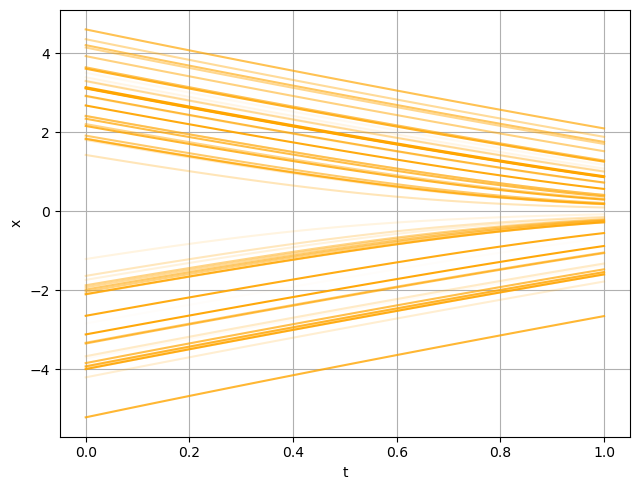

In [56]:
#plot trajectory
data=torch.load('data/mix_gaussian.pt').reshape(-1,1)
data=data[:50].to(device)
nt=40
h=1/nt
zFull = torch.zeros(*data.shape , nt+1, device=data.device, dtype=data.dtype) # make tensor of size z.shape[0], z.shape[1], nt
zFull[:,:,0] = data
tk=0

for k in  range(nt):
    zFull[:,:,k+1] = stepRK4(odefun, zFull[:,:,k] , f_theta, tk, tk+h)
    tk += h

print(zFull.shape)

def plot_generate_sequence(zFull, nt):
    fig, axs = plt.subplots(figsize=(6.5, 5))
    
    # 计算每条线的透明度
    num_lines = 50
    alpha_step = 1.0 / num_lines
    
    for i in range(num_lines):
        x = np.linspace(0, 1, nt + 1)
        y = zFull[i, :, :].view(nt + 1, 1).detach().cpu().numpy()
        plt.plot(x, y, color="orange", alpha=alpha_step * (i + 1))
    
    # 显示网格
    plt.grid(True)
    plt.xlabel("t")
    plt.ylabel("x")
    plt.tight_layout()
    plt.show()
plot_generate_sequence(zFull, nt)





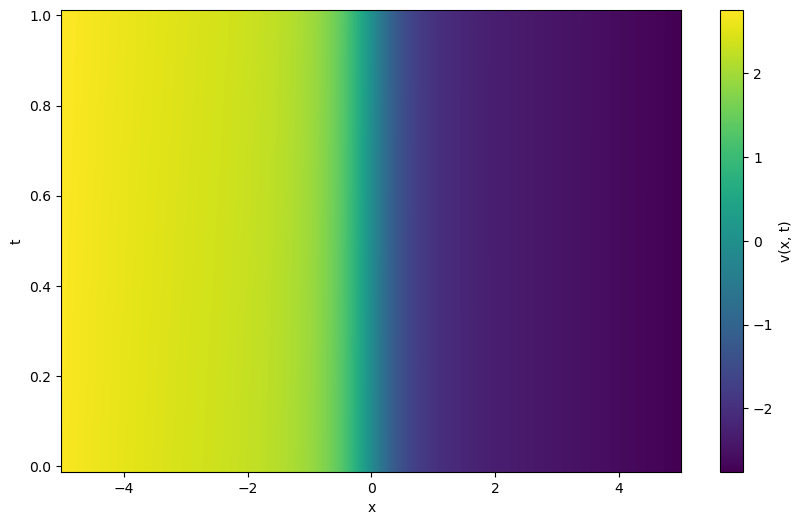

In [57]:
x_space = torch.linspace(-5, 5, 1000).view(-1,1).to(device)
V=torch.zeros(41,1000)
for i in range(41):
    V[i,:]=f_theta(x_space,t=i/40).squeeze()

x_space = np.linspace(-5, 5, 1000)
t_space = np.linspace(0, 1, 41)

X, T = np.meshgrid(x_space, t_space)

plt.figure(figsize=(10, 6))
plt.pcolormesh(X,T, V.detach().cpu().numpy(), shading='auto', cmap='viridis')
plt.colorbar(label='v(x, t)')
plt.xlabel('x')
plt.ylabel('t')

plt.show()

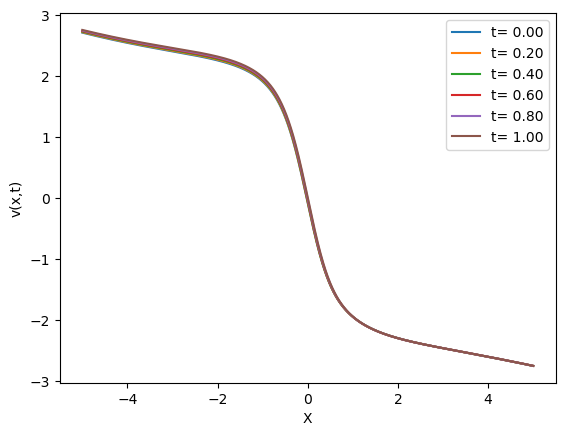

In [58]:
x_space = torch.linspace(-5, 5, 1000).view(-1,1).to(device)
for i in range(0,41,8):
    V=f_theta(x_space,t=i/40)
    plt.plot(x_space.detach().cpu().numpy(),V.detach().cpu().numpy(),label=f"t= {i/40:.2f}")
plt.xlabel("X")
plt.ylabel("v(x,t)")
plt.legend()